# la méthode d'Analyse de Similarités Multi-Facteurs (ASMF)
### 1 Identification des régimes de fonctionnement
### 2 Identification des paramètres prépondérants
### 3 Fusion des données
### 4 Analyse de similarités et prédiction de RUL


In [101]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl

from sklearn.preprocessing import MinMaxScaler ,StandardScaler#to normalize data
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

#### Prépare les données pour l'entraînement et le test d'un modèle de prédiction de RUL.


In [102]:
def prepare_data(feature_selection = True):
    dependent_var = ['RUL']
    column_names = ['engine', 'time', 'op_setting_1', 'op_setting_2', 
                'op_setting_3'] + [f'sm_{i}' for i in range(1, 22)]

    # voire la partie feature selection 
    #les features selectionnées
    features  = ['op_setting_1', 'op_setting_2',"sm_2", "sm_3", "sm_4", "sm_7", "sm_8",
             "sm_9", "sm_11" , "sm_12", "sm_13",  "sm_15", "sm_17", "sm_20", "sm_21"
            ]

    train_data = pd.read_csv('../../data/train_FD001.txt',delim_whitespace=True)
    train_data.columns=column_names
    
    max = pd.DataFrame(train_data.groupby('engine')['time'].max()).reset_index()
    max.columns = ['engine', 'max']
    train_data = train_data.merge(max, on=['engine'], how='left')
    train_data['RUL'] = train_data['max'] - train_data['time']
    train_data.drop('max', axis=1, inplace=True)

    test_data = pd.read_csv('../../data/test_FD001.txt', delim_whitespace=True, names=column_names)
    
    if(feature_selection == True):
        train_data = train_data[['engine', 'time' ]+features+['RUL']]
        test_data = test_data[['engine', 'time' ]+features]

    test_rul = pd.read_csv('../../data/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    test_rul["engine"] = test_rul.index +1
    
    return train_data, test_data, test_rul

In [103]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

C:\Users\user\AppData\Local\Temp\ipykernel_39220\4194414081.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv('../../data/train_FD001.txt',delim_whitespace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_39220\4194414081.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv('../../data/test_FD001.txt', delim_whitespace=True, names=column_names)
C:\Users\user\AppData\Local\Temp\ipykernel_39220\4194414081.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_rul = pd.read_csv('../../data/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])


((20630, 18), (13096, 17), (100, 2))

In [104]:
df_train

,engine,time,op_setting_1,op_setting_2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,RUL
0,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
1,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
2,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
3,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
4,1,6,-0.0043,-0.0001,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8.4108,391,38.98,23.3669,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20625,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20626,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20627,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20628,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


## Étape 1 : Identification des régimes de fonctionnement
1. Objectif
- Normaliser les données ES (sm_*) par régime de fonctionnement. ( dans notre cas 1 régime de fct)

##### CA ( "op_settings_1" , "op_settings_2", "op_settings_3")

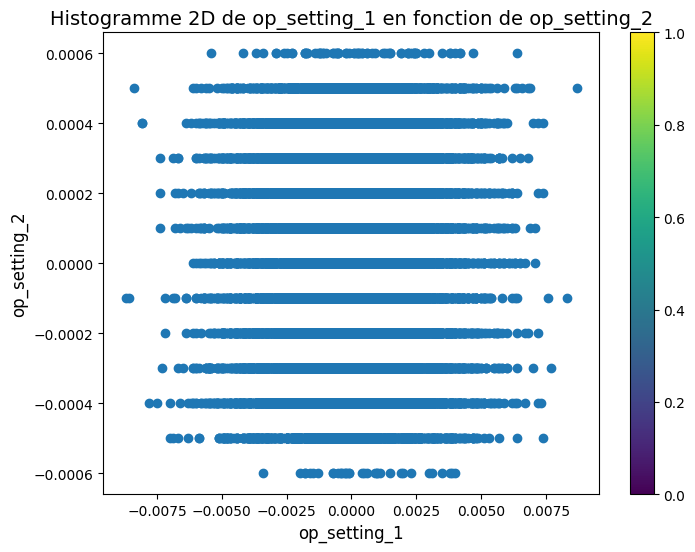

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_train['op_setting_1'], df_train['op_setting_2'])
plt.colorbar()
plt.title("Histogramme 2D de op_setting_1 en fonction de op_setting_2", fontsize=14)
plt.xlabel("op_setting_1", fontsize=12)
plt.ylabel("op_setting_2", fontsize=12)
plt.show()


In [106]:
feats = df_train.columns.drop(['engine', 'time', 'RUL','op_setting_1','op_setting_2'])

In [107]:
# Initialiser le StandardScaler pour la normalisation en Z
scaler = StandardScaler()

# Normaliser les données d'entraînement et de test en utilisant Z-score
df_train[feats] = scaler.fit_transform(df_train[feats])  # Appliquer le fit_transform sur les données d'entraînement
df_test[feats] = scaler.transform(df_test[feats])        # Appliquer le transform sur les données de test

In [108]:
df_train.head()

,engine,time,op_setting_1,op_setting_2,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,RUL
0,1,2,0.0019,-0.0003,-1.061914,0.211517,-0.643769,0.431987,-0.798104,-0.958853,-0.191592,1.174890,-0.363698,-0.275877,-0.781740,1.016613,1.236993,190
1,1,3,-0.0043,0.0003,-0.661928,-0.413162,-0.525996,1.008216,-0.234605,-0.557178,-1.015293,1.364708,-0.919895,-0.649163,-2.073113,0.739971,0.503486,189
2,1,4,0.0007,0.0000,-0.661928,-1.261291,-0.784873,1.222889,0.188020,-0.713863,-1.539467,1.961276,-0.224649,-1.971664,-0.781740,0.352671,0.777858,188
3,1,5,-0.0019,-0.0002,-0.621929,-1.251505,-0.301562,0.714452,-0.516354,-0.457098,-0.977852,1.052865,-0.780846,-0.339869,-0.136054,0.463328,1.059621,187
4,1,6,-0.0043,-0.0001,-1.161910,-0.987280,-1.173744,1.471459,-1.079853,-0.704806,-1.427144,0.361388,-0.919895,-0.835807,-1.427426,0.905956,0.713191,186


### 2 Identification des paramètres prépondérants
Les paramètres (features) sont sélectionnés lors de l'étape de Feature Selection. Pour plus de détails, consultez le fichier feature_selection.ipynb.

In [109]:
feats

Index(['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12',
       'sm_13', 'sm_15', 'sm_17', 'sm_20', 'sm_21'],
      dtype='object')

### 3. Fusion des données

Pour cette étape, nous créons un modèle de dégradation linéaire afin de fusionner les différentes caractéristiques identifiées.  



- Supposons que l'état de santé d'une unité se dégrade de manière linéaire. Cela peut être réalisé en redimensionnant le RUL sur une échelle de 1 à 0.

<Axes: xlabel='time', ylabel='HI'>

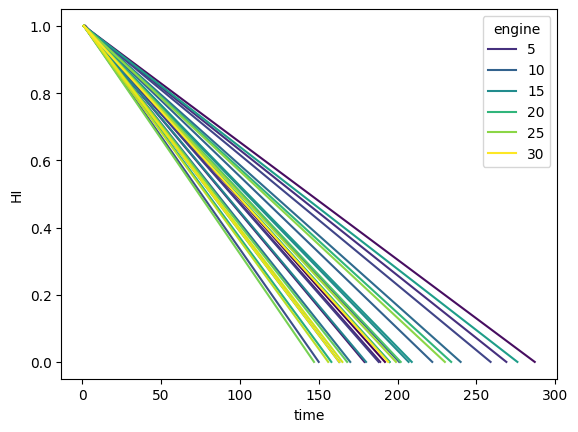

In [110]:
df_train['HI'] = df_train.groupby('engine').RUL.transform(lambda x: minmax_scale(x))

sns.lineplot(data= df_train[df_train.engine < 31], x = 'time', y = 'HI', hue= 'engine',palette=sns.color_palette("viridis", as_cmap=True))

### Construction d'un Modèle de Régression Linéaire pour l'Indicateur de Santé

- **Initialisation du Modèle** :
   Un modèle de régression linéaire est utilisé pour modéliser la relation entre les caractéristiques et l'indicateur de santé.


#### Linear Regression

In [111]:
model = LinearRegression()
X = df_train[feats]
y = df_train.HI

In [112]:
model.fit(X,y)

model.score(X,y)

0.6515388896752841

In [113]:
model.coef_

array([-0.01210292, -0.01229629, -0.03050321,  0.02669568,  0.002825  ,
       -0.06690842, -0.04265827,  0.03748155, -0.00106626, -0.0187827 ,
       -0.01377553,  0.01949557,  0.01958553])

In [114]:
model.intercept_

np.float64(0.50000000000001)

### Création d'un Nouvel Indicateur de Santé

Un nouvel indicateur de santé est construit en combinant linéairement les caractéristiques avec les coefficients du modèle :

\begin{equation*}
\text{New HI} = \sum_{i=1}^{n} (\text{coef}_i \times \text{feature}_i)
\end{equation*}


In [115]:
df_train['HI_final'] = model.predict(X)
# df_train['HI_final_normalized'] = minmax_scale(df_train['HI_final'])
df_train[["HI_final","HI"]].head()

,HI_final,HI
0,0.715916,1.000000
1,0.753150,0.994737
2,0.837737,0.989474
3,0.700365,0.984211
4,0.787792,0.978947


#### visualiser les indicateurs de santé finaux

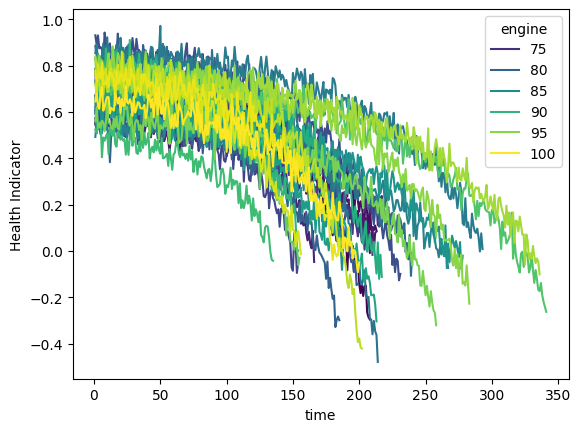

In [116]:
# Visualisation des indicateurs de santé finaux pour les unités 1 à 30
sns.lineplot(data=df_train[df_train.engine > 70], x='time', y='HI_final', hue='engine',palette=sns.color_palette("viridis", as_cmap=True))

# Ajouter un label sur l'axe Y
plt.ylabel('Health Indicator')

# Afficher le graphique
plt.show()

#### Calculer une moyenne mobile pour lisser l'indicateur de santé final

In [117]:
df_train_HI = df_train.groupby('engine')['HI_final'].rolling(window = 5).mean()
df_train_HI = df_train_HI.reset_index()
df_train_HI.dropna(inplace = True)
df_train_HI.drop(['level_1'], axis = 1, inplace = True)
df_train_HI['time'] = df_train_HI.groupby('engine').cumcount()+1
df_train_HI.head()

,engine,HI_final,time
4,1,0.758992,1
5,1,0.763716,2
6,1,0.771078,3
7,1,0.758959,4
8,1,0.769603,5


#### Visualisation des Indicateurs de Santé et des Pannes 

Text(0, 0.5, 'Health Indicator')

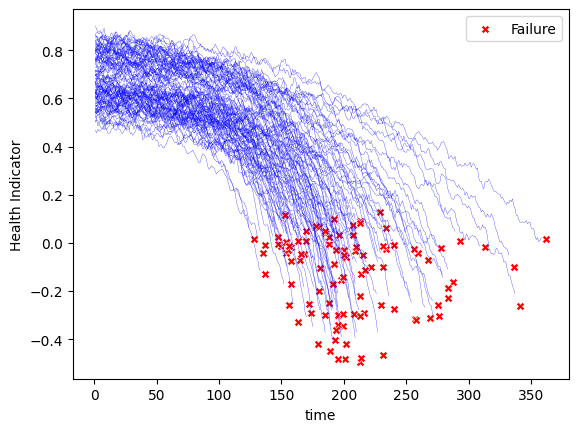

In [118]:
for i in range(1,101):
    sns.lineplot(data= df_train_HI[df_train_HI.engine == i], x = 'time', y = 'HI_final', color = 'blue', lw = 0.2)

sns.scatterplot(data = df_train[df_train.HI == 0], x = 'time', y = 'HI_final', label = 'Failure', 
                marker = 'X', color = 'red')
plt.ylabel('Health Indicator')

### Ajustement d'une fonction polynomiale de second ordre sur ces indicateurs de santé

L'objectif est de modéliser la relation entre l'indicateur de santé \( y \) et le cycle \( x \) à l'aide d'une fonction polynomiale de second ordre définie par l'équation suivante :

\begin{equation*}
y = \theta_0 + \theta_1 x + \theta_2 x^2
\end{equation*}

où :
- \( y \) est l'indicateur de santé.
- \( x \) est le cycle.




In [119]:
# Initialize the DataFrame with the required columns
params_df = pd.DataFrame(columns=['engine', 'theta_2', 'theta_1', 'theta_0'])

# Loop over engines 1 to 100
for i in range(1, 101):
    
    # Extract the 'HI_final' and 'time' values for the current engine
    y = df_train_HI.HI_final[df_train_HI.engine == i]
    cycle = df_train_HI.time[df_train_HI.engine == i]

    # Fit a second order polynomial to the data
    theta_2, theta_1, theta_0 = np.polyfit(cycle, y, 2)

    # Create a new DataFrame with the results for this engine
    new_row = pd.DataFrame({'engine': [i], 'theta_0': [theta_0], 'theta_1': [theta_1], 'theta_2': [theta_2]})
    
    # Concatenate the new row to the existing DataFrame
    params_df = pd.concat([params_df, new_row], ignore_index=True)

# Display the first few rows of the result
params_df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_39220\2183217813.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params_df = pd.concat([params_df, new_row], ignore_index=True)


,engine,theta_2,theta_1,theta_0
0,1,-0.000027,0.001966,0.712823
1,2,-0.000018,0.002191,0.790749
2,3,-0.000053,0.004693,0.683020
3,4,-0.000049,0.005067,0.579206
4,5,-0.000021,0.002519,0.730574


#### visualiser les indicateurs de santé ajustés pour 12 moteurs choisis au hasard, 

In [120]:
import random

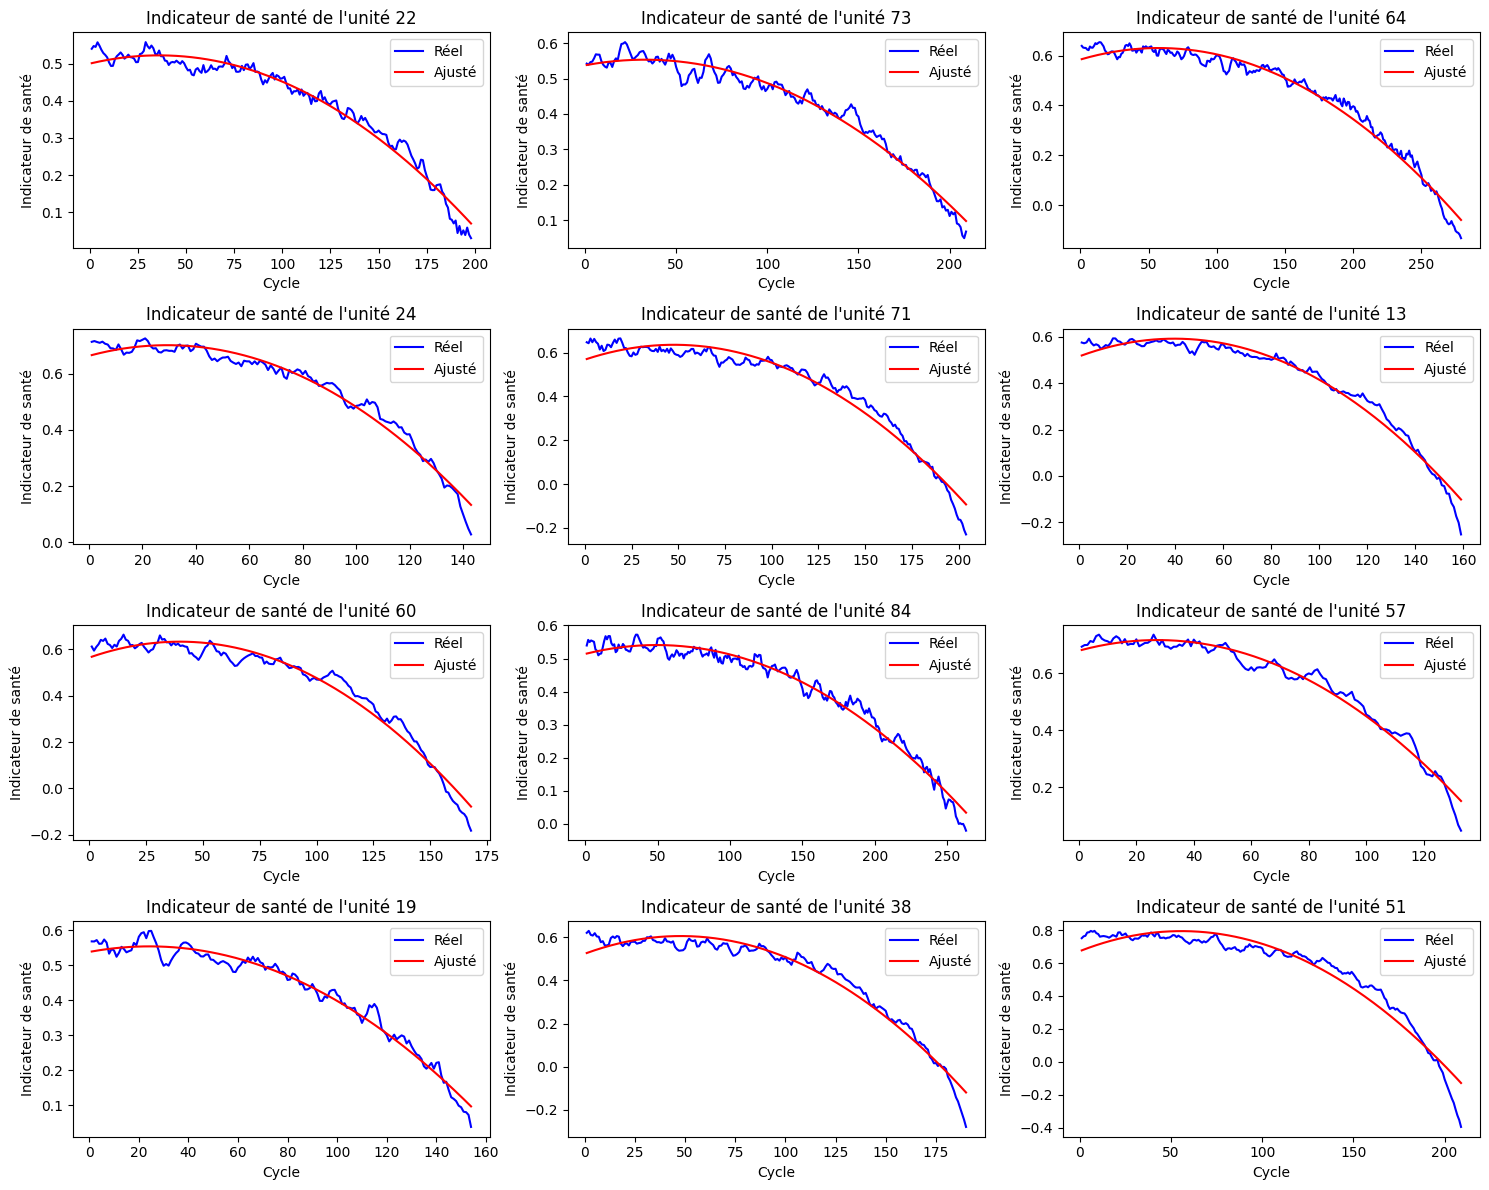

In [121]:
# Sélectionner 12 moteurs au hasard dans le dataset
moteurs_aleatoires = random.sample(range(1, 101), 12)

# Créer une figure pour les sous-graphiques (3 colonnes et 4 lignes)
fig, axes = plt.subplots(4, 3, figsize=(15, 12))

# Aplatir le tableau des axes pour une itération plus facile
axes = axes.flatten()

# Boucle sur les moteurs sélectionnés et tracer les graphiques
for idx, moteur in enumerate(moteurs_aleatoires):
    # Extraire l'indicateur de santé réel (HI) et les cycles pour le moteur actuel
    HI = df_train_HI.HI_final[df_train_HI.engine == moteur]
    cycle = df_train_HI.time[df_train_HI.engine == moteur]

    # Obtenir les coefficients pour le moteur actuel depuis params_df
    theta_0 = params_df.theta_0[params_df.engine == moteur].values[0]
    theta_1 = params_df.theta_1[params_df.engine == moteur].values[0]
    theta_2 = params_df.theta_2[params_df.engine == moteur].values[0]

    # Calculer l'indicateur de santé ajusté (HI) avec le polynôme du second ordre
    HI_ajuste = theta_0 + theta_1 * cycle + theta_2 * cycle ** 2

    # Tracer l'indicateur de santé réel et l'indicateur de santé ajusté sur le sous-graphe correspondant
    axes[idx].plot(cycle, HI, label='Réel', color='blue')
    axes[idx].plot(cycle, HI_ajuste, label='Ajusté', color='red')

    # Ajouter les labels, légende et titre pour chaque sous-graphe
    axes[idx].set_ylabel('Indicateur de santé')
    axes[idx].set_xlabel('Cycle')
    axes[idx].set_title(f'Indicateur de santé de l\'unité {moteur}')
    axes[idx].legend()

# Ajuster la disposition pour éviter que les sous-graphiques ne se chevauchent
plt.tight_layout()

# Afficher le graphique
plt.show()

### Construction d'un modèle RUL basé sur la similarité

#### Étapes :

1. **Générer un indicateur de santé** en multipliant les poids des caractéristiques sélectionnées dans les données de test.

2. **Prendre la moyenne roulante** de l'indicateur de santé pour réduire le bruit.

3. **Comparer les modèles polynomiaux ajustés** avec les indicateurs de santé des données de test et trouver les résidus en norme 1 en utilisant l'équation ci-dessous :

    \begin{equation*}
    d(i,j) = ||y_j - \hat{y_{j,i}} ||_1
    \end{equation*}

   t l'indicateur de santé ajusté prédit par le modèle polynomial pour l'unité \( j \) et le moteur \( i \).

4. **Calculer le score de similarité** en utilisant la formule suivante :

    \begin{equation*}
    score(i,j) = exp(-d(i,j)^2)
    \end{equation*}


5. **Trouver les 50 modèles les plus similaires** en triant les scores de similarité.

6. **Calculer le RUL** en soustrayant le cycle actuel du nombre total de cycles des unités les plus similaires.



#### Etape 1

In [122]:
df_test['HI'] =model.predict(df_test[feats])
df_test.HI.head()

0    0.718312
1    0.765831
2    0.672051
3    0.726829
4    0.782242
Name: HI, dtype: float64

#### Etape 2

In [123]:
df_test_HI = df_test.groupby('engine')['HI'].rolling(window = 5).mean()
df_test_HI = df_test_HI.reset_index()
df_test_HI.dropna(inplace = True)
df_test_HI.drop(['level_1'], axis = 1, inplace = True)
df_test_HI['time'] = df_test_HI.groupby('engine').cumcount()+1
df_test_HI.head()

,engine,HI,time
4,1,0.733053,1
5,1,0.741368,2
6,1,0.734913,3
7,1,0.745227,4
8,1,0.745444,5


#### Etape 4 et 5

In [124]:
df_test_fit = pd.DataFrame(columns = ['engine', 'Model', 'Residual', 'similarity', 'total_life'])

for i in df_test_HI.engine.unique():
    
    HI = df_test_HI.HI[df_test_HI.engine == i]
    cycle = df_test_HI.time[df_test_HI.engine == i]
        
    for j in params_df.engine.unique():
        
        theta_0 = params_df.theta_0[params_df.engine == j].values
        theta_1 = params_df.theta_1[params_df.engine == j].values
        theta_2 = params_df.theta_2[params_df.engine == j].values
        
        pred_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
        
        Residual = np.mean(np.abs(pred_HI - HI))

        total_life = df_train.time[df_train.engine == j].max()
        
        similarity_score = np.exp(-Residual*Residual)
        
        # Créez un DataFrame temporaire pour chaque itération
        temp_df = pd.DataFrame({'engine': [i], 'Model': [j], 'Residual': [Residual], 
                                'similarity': [similarity_score], 'total_life': [total_life]})

        # Utilisez pd.concat() pour concaténer le DataFrame temporaire à df_test_fit
        df_test_fit = pd.concat([df_test_fit, temp_df], ignore_index=True)


C:\Users\user\AppData\Local\Temp\ipykernel_39220\1321561043.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_fit = pd.concat([df_test_fit, temp_df], ignore_index=True)


#### Etape 5 et 6

In [125]:
ind_5 = df_test_fit.groupby('engine')['similarity'].nlargest(2).reset_index()['level_1']
result_df_5 = df_test_fit.iloc[ind_5]
result_df_5


,engine,Model,Residual,similarity,total_life
97,1,98,0.014891,0.999778,156
0,1,1,0.018233,0.999668,192
186,2,87,0.018402,0.999661,178
148,2,49,0.021539,0.999536,215
275,3,76,0.016646,0.999723,210
...,...,...,...,...,...
9799,98,100,0.025633,0.999343,200
9814,99,15,0.014447,0.999791,207
9832,99,33,0.016416,0.999731,200
9988,100,89,0.028734,0.999175,217


In [126]:
len(result_df_5)

200

Text(0.5, 1.0, '5 Nearest neighbors of Test Unit 5')

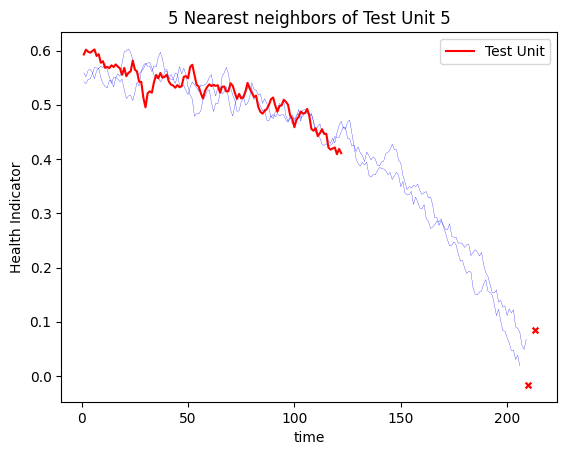

In [136]:
dff = result_df_5[result_df_5.engine == 3]

for i in dff.Model.unique():
    sns.lineplot(data= df_train_HI[df_train_HI.engine == i], x = 'time', y = 'HI_final', color = 'blue', lw = 0.2)
    sns.scatterplot(data = df_train[(df_train_HI.engine == i) & (df_train.HI == 0)], x = 'time', y = 'HI_final', 
                    marker = 'X', color = 'red')

sns.lineplot(data= df_test_HI[df_test_HI.engine == 3], x = 'time', y = 'HI', color = 'red', 
             label = 'Test Unit')
plt.ylabel('Health Indicator')
plt.title('5 Nearest neighbors of Test Unit 5')

#### Etape 7

In [137]:
y_true_5 = y_true.copy()

y_true_5['Pred_RUL'] = (result_df_5.groupby('engine')['total_life'].mean() - df_test.groupby('engine')['time'].max()).values
y_true_5.head()

,RUL,engine,Pred_RUL
0,112,1,143.0
1,98,2,147.5
2,69,3,85.5
3,82,4,77.0
4,91,5,76.0


#### K ?

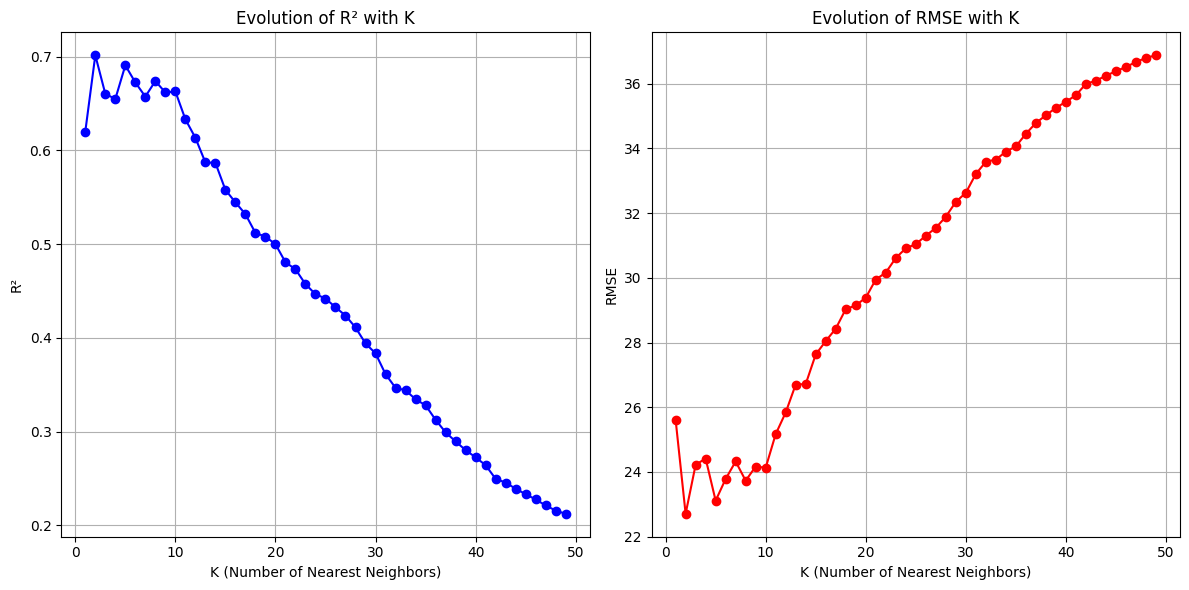

Meilleur K selon RMSE : 2
Meilleur K selon R² : 2


In [129]:
# Initialisation des variables pour stocker les résultats
k_values = range(1, 50)  # K allant de 1 à 10 (ou une autre plage)
rmse_values = []
r2_values = []

# Fonction pour calculer RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Boucle pour tester différentes valeurs de K
for k in k_values:
    # Sélectionner les k plus proches voisins
    ind_k = df_test_fit.groupby('engine')['similarity'].nlargest(k).reset_index()['level_1']
    result_df_k = df_test_fit.iloc[ind_k]
    
    # Calculer Pred_RUL pour ce K
    y_true_5['Pred_RUL'] = (result_df_k.groupby('engine')['total_life'].mean() - df_test.groupby('engine')['time'].max()).values
    
    # Calculer R² et RMSE pour cette valeur de K
    r2 = r2_score(y_true_5['RUL'], y_true_5['Pred_RUL'])
    rmse = root_mean_squared_error(y_true_5['RUL'], y_true_5['Pred_RUL'])
    
    # Sauvegarder les résultats
    r2_values.append(r2)
    rmse_values.append(rmse)

# Tracer l'évolution de R² et RMSE en fonction de K
plt.figure(figsize=(12, 6))

# Sous-graphe pour R²
plt.subplot(1, 2, 1)
plt.plot(k_values, r2_values, marker='o', color='b', label='R²')
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('R²')
plt.title('Evolution of R² with K')
plt.grid(True)

# Sous-graphe pour RMSE
plt.subplot(1, 2, 2)
plt.plot(k_values, rmse_values, marker='o', color='r', label='RMSE')
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('RMSE')
plt.title('Evolution of RMSE with K')
plt.grid(True)

# Afficher les graphiques
plt.tight_layout()
plt.show()

# Identifier la meilleure valeur de K en fonction de la minimisation de RMSE ou maximisation de R²
best_k_rmse = k_values[np.argmin(rmse_values)]
best_k_r2 = k_values[np.argmax(r2_values)]

print(f"Meilleur K selon RMSE : {best_k_rmse}")
print(f"Meilleur K selon R² : {best_k_r2}")


### Results

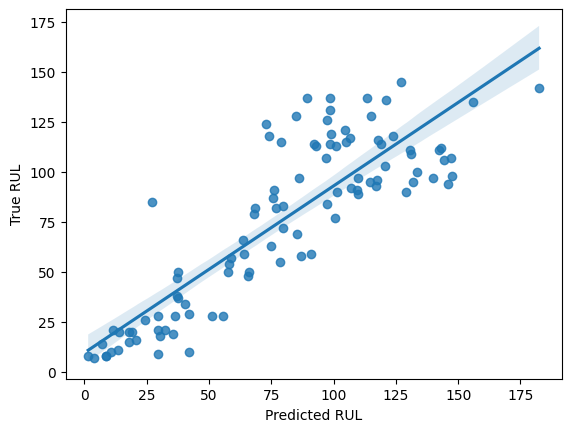

In [138]:
y_true_5['Pred_RUL'] = pd.to_numeric(y_true_5['Pred_RUL'], errors='coerce')
y_true_5['RUL'] = pd.to_numeric(y_true_5['RUL'], errors='coerce')

# Visualisation de la relation entre le RUL prédit et le RUL réel
sns.regplot(x='Pred_RUL', y='RUL', data=y_true_5)
# Ajouter les labels aux axes
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

# Afficher le graphique
plt.show()


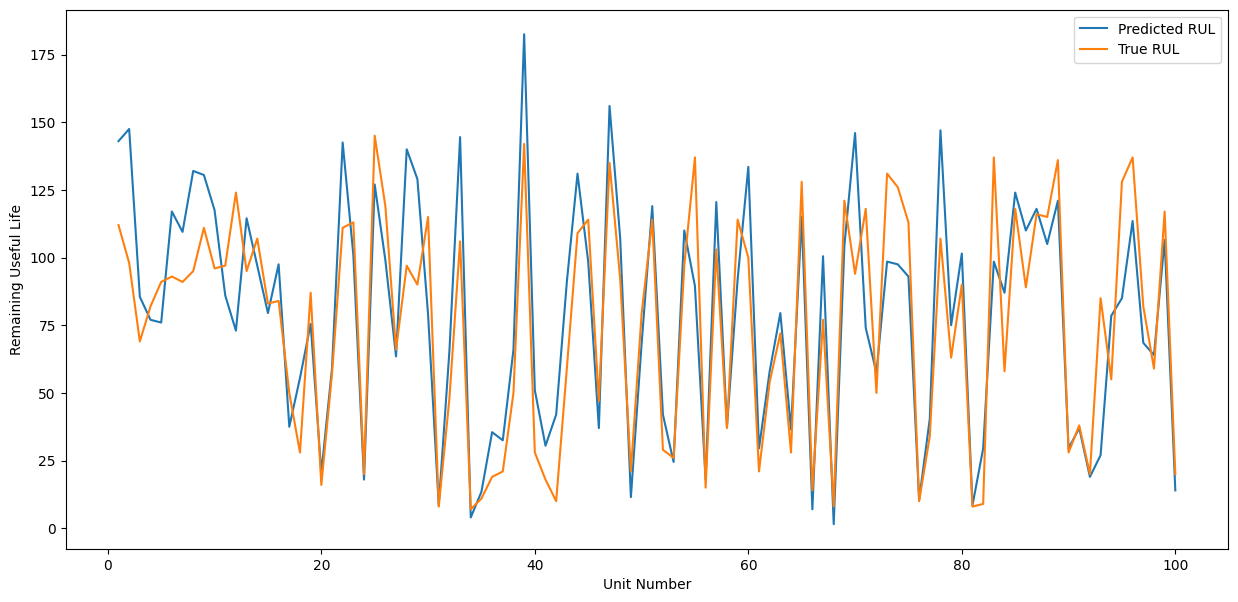

In [139]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_true_5.engine, y = y_true_5.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_true_5.engine, y = y_true_5.RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

### Errors

In [132]:
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score, root_mean_squared_error

In [140]:
rmse=root_mean_squared_error(y_true_5.RUL, y_true_5.Pred_RUL)
rmse

np.float64(22.70644181724649)

In [141]:
mae=mean_absolute_error(y_true_5.RUL, y_true_5.Pred_RUL)
mae

np.float64(17.935)

In [142]:
r_2=r2_score(y_true_5.RUL, y_true_5.Pred_RUL)
r_2

0.7014351865363777